put CNN, NN, and RF stuff all in one df.
by 'stuff' I mean specz, photoz, absolute bias, object id, and other metrics. maybe just bias for now.
then filter by CNN bias such that the df only has samples where the CNN bias is less than the LSST requirement of 0.003.
sort the df by the CNN bias.
this time, instead of the difference in predicted redshifts, look for differences in absolute bias.
subtract the CNN bias from the NN or RF bias, basically.
then look at the top few images in both the best performing and worst performing images relative to the magnitudes.
best performing means the biases are the most negative and worst performing means the biases are the most positive.
negatives mark reduction and positives mark increases, basically.
limit redshift range if you want.

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import os
from photoz_utils import *

In [2]:
GB_LIMIT = 1
NUM_GALAXIES = 20
Z_MIN = 0
Z_MAX = 4
LSST_BIAS = 0.003
TOGGLE_IMAGES = False # false to reduce notebook size

# don't change these
BEST_PERFORMING = True 
WORST_PERFORMING = False

In [3]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1000*GB_LIMIT)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
NN_PATH = '/predictions/HSC_v6_NN_step2A_small_subset_v1/testing_predictions_big.csv'
RF_PATH = '/predictions/HSC_v6_RandomForest_step2A_small_subset_v1/testing_predictions_big.csv'
CNN_PATH = '/predictions/HSC_v6_CNNTrials_5_pooling_2x2_filters_doubled_v3/testing_predictions_big.csv'

In [5]:
nn_df = pd.read_csv(NN_PATH)
rf_df = pd.read_csv(RF_PATH)
cnn_df = pd.read_csv(CNN_PATH)

nn_df = nn_df[['object_id', 'specz', 'photoz']]
rf_df = rf_df[['object_id', 'specz', 'photoz']]
cnn_df = cnn_df[['object_id', 'specz', 'photoz']]

In [6]:
test_hf = h5py.File('/data/HSC/HSC_v6/step2A/127x127/five_band_image127x127_with_metadata_corrected_testing.hdf5', 'r')

In [7]:
test_hf.keys()

<KeysViewHDF5 ['coord', 'dec', 'g_cmodel_mag', 'g_cmodel_magsigma', 'i_cmodel_mag', 'i_cmodel_magsigma', 'image', 'object_id', 'r_cmodel_mag', 'r_cmodel_magsigma', 'ra', 'skymap_id', 'specz_dec', 'specz_flag_homogeneous', 'specz_mag_i', 'specz_name', 'specz_ra', 'specz_redshift', 'specz_redshift_err', 'y_cmodel_mag', 'y_cmodel_magsigma', 'z_cmodel_mag', 'z_cmodel_magsigma']>

In [8]:
nn_df['bias'] = pd.Series([np.abs(calculate_bias(i, j, conventional=True)) for i, j in zip(nn_df['photoz'], nn_df['specz'])])
rf_df['bias'] = pd.Series([np.abs(calculate_bias(i, j, conventional=True)) for i, j in zip(rf_df['photoz'], rf_df['specz'])])
cnn_df['bias'] = pd.Series([np.abs(calculate_bias(i, j, conventional=True)) for i, j in zip(cnn_df['photoz'], cnn_df['specz'])])

In [9]:
# Specify the different models
nn_df.columns.values[2:] += '_nn'
rf_df.columns.values[2:] += '_rf'
cnn_df.columns.values[2:] += '_cnn'

In [10]:
mags = ['g_cmodel_mag', 'r_cmodel_mag', 'i_cmodel_mag', 'z_cmodel_mag', 'y_cmodel_mag']
mags_err = ['g_cmodel_magsigma', 'r_cmodel_magsigma', 'i_cmodel_magsigma', 'z_cmodel_magsigma', 'y_cmodel_magsigma']
mag_alpha = ['g', 'r', 'i', 'z', 'y']
# Add mag info
for mag, mag_err in zip(mags, mags_err):
    nn_df[mag] = pd.Series(test_hf[mag][:])
    nn_df[mag_err] = pd.Series(test_hf[mag_err][:])
    rf_df[mag] = pd.Series(test_hf[mag][:])
    rf_df[mag_err] = pd.Series(test_hf[mag_err][:])
    cnn_df[mag] = pd.Series(test_hf[mag][:])
    cnn_df[mag_err] = pd.Series(test_hf[mag_err][:])

In [11]:
# Limit specz range
nn_df = nn_df[(Z_MIN <= nn_df['specz']) & (nn_df['specz'] <= Z_MAX)]
rf_df = rf_df[(Z_MIN <= rf_df['specz']) & (rf_df['specz'] <= Z_MAX)]
cnn_df = cnn_df[(Z_MIN <= cnn_df['specz']) & (cnn_df['specz'] <= Z_MAX)]

In [12]:
merge_by_arr = list(np.delete(nn_df.columns.values, [2, 3])) # create array of shared columns to merge by

full_df = pd.merge(pd.merge(nn_df, rf_df, on=merge_by_arr), cnn_df, on=merge_by_arr)

In [13]:
best_df = full_df[(full_df['bias_cnn'] < LSST_BIAS)] 
# filter so the df only has cnn biases that meet LSST requirements

In [14]:
worst_df = full_df[(full_df['bias_cnn'] > LSST_BIAS)] 
# filter so the df only has cnn biases that don't meet LSST requirements

In [15]:
rf_nn_best_df = full_df[(full_df['bias_cnn'] > LSST_BIAS) & (full_df['bias_nn'] < LSST_BIAS) & (full_df['bias_rf'] < LSST_BIAS)]
# filter so the df only has cnn biases that don't meet LSST requirements, and nn/rf biases that meet LSST requirements

In [16]:
best_df['cnn_nn_diff'] = pd.Series(best_df['bias_cnn'] - best_df['bias_nn'])
best_df['cnn_rf_diff'] = pd.Series(best_df['bias_cnn'] - best_df['bias_rf'])

worst_df['cnn_nn_diff'] = pd.Series(worst_df['bias_cnn'] - worst_df['bias_nn'])
worst_df['cnn_rf_diff'] = pd.Series(worst_df['bias_cnn'] - worst_df['bias_rf'])

rf_nn_best_df['cnn_nn_diff'] = pd.Series(rf_nn_best_df['bias_cnn'] - rf_nn_best_df['bias_nn'])
rf_nn_best_df['cnn_rf_diff'] = pd.Series(rf_nn_best_df['bias_cnn'] - rf_nn_best_df['bias_rf'])

<ipython-input-16-f6f089e66d1c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_df['cnn_nn_diff'] = pd.Series(best_df['bias_cnn'] - best_df['bias_nn'])
<ipython-input-16-f6f089e66d1c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_df['cnn_rf_diff'] = pd.Series(best_df['bias_cnn'] - best_df['bias_rf'])
<ipython-input-16-f6f089e66d1c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [17]:
best_df

,object_id,specz,photoz_nn,bias_nn,g_cmodel_mag,g_cmodel_magsigma,r_cmodel_mag,r_cmodel_magsigma,i_cmodel_mag,i_cmodel_magsigma,z_cmodel_mag,z_cmodel_magsigma,y_cmodel_mag,y_cmodel_magsigma,photoz_rf,bias_rf,photoz_cnn,bias_cnn,cnn_nn_diff,cnn_rf_diff
5,36411439950351989,0.05605,0.126601,0.066807,17.381647,0.000864,16.399513,0.000636,15.817790,0.000528,15.458609,0.000655,15.198736,0.000894,0.083072,0.025588,0.058360,0.002187,-0.064620,-0.023400
25,36411860857155041,0.31632,0.317685,0.001037,20.303215,0.002497,18.818241,0.001171,18.165604,0.001005,17.839886,0.001353,17.659870,0.001961,0.316062,0.000196,0.312923,0.002581,0.001544,0.002385
36,36412410612959067,0.43589,0.417959,0.012487,21.627251,0.008348,19.966717,0.003409,19.221607,0.002264,18.816086,0.002531,18.628080,0.004286,0.419611,0.011337,0.436212,0.000225,-0.012263,-0.011113
54,36416121464690048,1.21358,1.281772,0.030806,19.865452,0.001564,19.492760,0.001512,19.559063,0.000856,19.580213,0.001589,19.502684,0.003500,1.449409,0.106538,1.215180,0.000723,-0.030083,-0.105815
64,36416258903659782,0.43271,0.403429,0.020437,21.286842,0.005424,19.626164,0.002004,18.849026,0.001079,18.467773,0.001744,18.246525,0.003015,0.402076,0.021382,0.429713,0.002092,-0.018346,-0.019290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42917,74649147239571217,1.16155,1.287098,0.058083,23.449385,0.014849,23.195126,0.025908,22.785377,0.016353,22.202217,0.023735,21.746195,0.067016,1.298177,0.063208,1.159345,0.001020,-0.057063,-0.062188
42924,74649147239589513,0.61779,0.560569,0.035370,22.357910,0.005361,20.852676,0.002798,19.946104,0.001193,19.617573,0.001951,19.475075,0.003796,0.523386,0.058354,0.620163,0.001467,-0.033903,-0.056887
42948,74649151534561704,0.07561,0.135165,0.055369,18.600433,0.000967,17.630979,0.000858,17.078575,0.000684,16.813429,0.000982,16.611706,0.001552,0.120510,0.041744,0.076565,0.000888,-0.054481,-0.040855
42950,74649151534562493,0.67004,0.730708,0.036327,24.283411,0.021435,22.714470,0.009857,21.456547,0.003428,21.005642,0.005552,20.802650,0.009493,0.686589,0.009909,0.666773,0.001956,-0.034371,-0.007953


In [18]:
worst_df

,object_id,specz,photoz_nn,bias_nn,g_cmodel_mag,g_cmodel_magsigma,r_cmodel_mag,r_cmodel_magsigma,i_cmodel_mag,i_cmodel_magsigma,z_cmodel_mag,z_cmodel_magsigma,y_cmodel_mag,y_cmodel_magsigma,photoz_rf,bias_rf,photoz_cnn,bias_cnn,cnn_nn_diff,cnn_rf_diff
0,36407046198803509,0.43602,0.283698,0.106072,20.320715,0.005252,18.924778,0.002675,18.247103,0.002002,17.874811,0.002538,17.614677,0.003533,0.286485,0.104132,0.313406,0.085385,-0.020688,-0.018747
1,36407046198804043,0.23209,0.218118,0.011340,19.497759,0.003118,18.092823,0.001437,17.458420,0.001168,17.047669,0.001473,16.851135,0.001957,0.232045,0.000037,0.221517,0.008582,-0.002759,0.008545
2,36407050493759629,0.56511,0.532262,0.020988,21.629736,0.013312,19.881702,0.005301,18.808056,0.002215,18.372108,0.002606,18.164425,0.004169,0.561226,0.002481,0.591767,0.017032,-0.003956,0.014551
3,36407050493773284,0.55775,0.577122,0.012436,22.469265,0.016712,20.791992,0.007284,19.745741,0.003369,19.327951,0.003647,19.115318,0.006003,0.547213,0.006764,0.566604,0.005684,-0.006752,-0.001080
4,36407054788744371,0.44495,0.462666,0.012260,21.639175,0.007790,19.897354,0.002991,19.061874,0.002310,18.658112,0.002441,18.476147,0.004695,0.453314,0.005788,0.425878,0.013199,0.000939,0.007411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42954,74649160124473065,3.25964,2.178847,0.253729,23.034283,0.007589,22.521007,0.008181,22.596773,0.006210,22.649017,0.020605,22.298950,0.035997,1.195179,0.484656,2.275697,0.230992,-0.022737,-0.253664
42955,74649160124473935,0.76575,0.862959,0.055052,22.637253,0.006570,22.268681,0.009577,21.880810,0.005297,21.404089,0.008812,21.640312,0.033616,0.959811,0.109903,0.816059,0.028492,-0.026561,-0.081411
42956,74649160124493654,0.98303,0.931368,0.026052,22.516769,0.008390,22.025034,0.011928,21.326210,0.006170,20.916145,0.010334,20.752903,0.022262,0.881192,0.051355,0.997014,0.007052,-0.019001,-0.044303
42957,74649160124502454,0.67514,0.631052,0.026319,22.010475,0.007374,20.684258,0.004796,19.686981,0.001830,19.279902,0.003034,18.977123,0.005242,0.603995,0.042471,0.662268,0.007684,-0.018635,-0.034787


In [19]:
rf_nn_best_df

,object_id,specz,photoz_nn,bias_nn,g_cmodel_mag,g_cmodel_magsigma,r_cmodel_mag,r_cmodel_magsigma,i_cmodel_mag,i_cmodel_magsigma,z_cmodel_mag,z_cmodel_magsigma,y_cmodel_mag,y_cmodel_magsigma,photoz_rf,bias_rf,photoz_cnn,bias_cnn,cnn_nn_diff,cnn_rf_diff
90,36416812954426809,0.48207,0.486059,0.002691,21.969544,0.012002,20.256453,0.003523,19.380417,0.001612,18.983376,0.002335,18.801908,0.004066,0.486321,0.002868,0.493800,0.007915,0.005224,0.005047
104,36420373482324924,0.53630,0.537062,0.000496,22.339468,0.015797,20.689018,0.005786,19.719845,0.002303,19.305351,0.002987,19.134718,0.005243,0.533243,0.001990,0.564602,0.018422,0.017926,0.016432
211,36429465928096221,0.51326,0.512608,0.000431,22.215801,0.009666,20.489824,0.002916,19.514879,0.001353,19.090736,0.002063,18.887829,0.003882,0.514385,0.000744,0.547533,0.022649,0.022218,0.021905
270,36434125967598087,0.47830,0.474489,0.002578,22.084316,0.009824,20.374037,0.003878,19.521721,0.001252,19.109211,0.001890,18.901001,0.003976,0.474529,0.002551,0.492578,0.009659,0.007081,0.007108
284,36434409435437395,0.50269,0.505399,0.001803,22.177570,0.008557,20.497271,0.002775,19.585882,0.001573,19.171482,0.002308,18.963759,0.004872,0.500309,0.001585,0.528730,0.017329,0.015526,0.015744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40748,70404233492434848,0.08804,0.085834,0.002027,17.005217,0.000422,16.070379,0.000276,15.527135,0.000249,15.207407,0.000295,15.009348,0.000506,0.087190,0.000781,0.095414,0.006778,0.004751,0.005997
40887,70413411837575057,0.63105,0.632260,0.000742,23.040434,0.016786,21.273743,0.004704,20.047245,0.001706,19.537483,0.002687,19.299667,0.003917,0.629239,0.001110,0.667279,0.022212,0.021471,0.021102
40919,70417397567200029,0.36104,0.359127,0.001406,20.765305,0.002206,19.100451,0.001020,18.450428,0.000674,18.118444,0.000939,17.956974,0.001464,0.364425,0.002487,0.352681,0.006142,0.004736,0.003655
41235,74643645386465115,0.65006,0.647896,0.001311,23.390491,0.016257,21.776239,0.007535,20.593510,0.002522,20.146225,0.003961,19.878479,0.007045,0.652026,0.001191,0.693757,0.026482,0.025171,0.025291


In [20]:
cnn_nn_best = best_df.sort_values(by=['cnn_nn_diff'], ascending=BEST_PERFORMING)
cnn_rf_best = best_df.sort_values(by=['cnn_rf_diff'], ascending=BEST_PERFORMING)

cnn_nn_worst = worst_df.sort_values(by=['cnn_nn_diff'], ascending=WORST_PERFORMING)
cnn_rf_worst = worst_df.sort_values(by=['cnn_rf_diff'], ascending=WORST_PERFORMING)

rf_best = rf_nn_best_df.sort_values(by=['cnn_rf_diff'], ascending=WORST_PERFORMING)
nn_best = rf_nn_best_df.sort_values(by=['cnn_nn_diff'], ascending=WORST_PERFORMING)

# performance mode indicates what mode the CNN bias is sorted by

In [21]:
cnn_nn_best

,object_id,specz,photoz_nn,bias_nn,g_cmodel_mag,g_cmodel_magsigma,r_cmodel_mag,r_cmodel_magsigma,i_cmodel_mag,i_cmodel_magsigma,z_cmodel_mag,z_cmodel_magsigma,y_cmodel_mag,y_cmodel_magsigma,photoz_rf,bias_rf,photoz_cnn,bias_cnn,cnn_nn_diff,cnn_rf_diff
40074,70365041915877073,0.209333,2.298409,1.727462,20.939396,0.006759,20.391289,0.004909,20.199217,0.004134,20.173031,0.005642,20.224075,0.009329,1.571517,1.126393,0.205743,0.002968,-1.724494,-1.123425
16490,41579711536596015,0.094230,1.803216,1.561816,19.777716,0.001744,19.451578,0.001427,19.375889,0.001520,19.069920,0.002298,18.850060,0.004101,1.292686,1.095251,0.094078,0.000139,-1.561677,-1.095111
10864,41021550471707938,0.065730,1.515024,1.359908,20.976364,0.004788,20.924738,0.005857,20.642412,0.003768,20.728413,0.009812,20.506249,0.018614,1.733122,1.564554,0.066774,0.000980,-1.358928,-1.563574
6090,39935241573388804,0.068960,1.359743,1.207513,19.923796,0.004506,19.669414,0.005188,19.481480,0.004383,19.345255,0.037464,19.463173,0.060340,1.584030,1.417330,0.068808,0.000142,-1.207371,-1.417189
5432,39600448872667363,0.136283,1.502387,1.202257,20.204815,0.003969,20.016647,0.003717,19.693857,0.004500,19.837912,0.006127,19.896181,0.009943,1.527940,1.224746,0.133454,0.002489,-1.199768,-1.222256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35556,43704075375607942,0.954400,0.954774,0.000192,23.490589,0.017573,22.976685,0.014652,22.085564,0.005869,21.832722,0.011134,21.453238,0.018503,0.831357,0.062957,0.949035,0.002745,0.002553,-0.060212
28338,42657628068774563,0.135050,0.135102,0.000046,18.630497,0.000842,17.666470,0.000543,17.106884,0.000422,16.740175,0.000644,16.592300,0.000787,0.133357,0.001491,0.132022,0.002667,0.002622,0.001176
1723,37485134529696261,0.600160,0.600647,0.000305,22.033935,0.008480,20.395252,0.003945,19.257975,0.001756,18.806076,0.002511,18.609509,0.004014,0.593314,0.004279,0.604857,0.002935,0.002631,-0.001343
32550,43149672407105816,0.385570,0.385530,0.000029,21.306122,0.011128,19.624142,0.003625,18.899383,0.002046,18.490669,0.002847,18.246162,0.004212,0.383682,0.001363,0.389357,0.002733,0.002705,0.001371


In [22]:
cnn_nn_worst

,object_id,specz,photoz_nn,bias_nn,g_cmodel_mag,g_cmodel_magsigma,r_cmodel_mag,r_cmodel_magsigma,i_cmodel_mag,i_cmodel_magsigma,z_cmodel_mag,z_cmodel_magsigma,y_cmodel_mag,y_cmodel_magsigma,photoz_rf,bias_rf,photoz_cnn,bias_cnn,cnn_nn_diff,cnn_rf_diff
40777,70404774658318352,0.320020,0.276541,0.032938,20.554527,0.001414,19.324402,0.000766,19.738140,0.001093,18.763777,0.000831,19.293434,0.002820,2.209383,1.431314,3.181005,2.167380,2.134442,0.736067
35206,43699548480108076,0.416400,0.471705,0.039047,22.933529,0.012958,22.250454,0.012362,22.065193,0.007536,21.845467,0.018219,21.652435,0.029453,0.445713,0.020695,3.073347,1.875845,1.836799,1.855150
25907,42310315538391680,0.542980,0.348502,0.126041,20.976879,0.001928,19.573309,0.000843,19.237305,0.000537,19.065727,0.000873,18.941780,0.001788,1.068044,0.340292,3.463088,1.892512,1.766471,1.552219
27163,42635655016116424,0.527700,0.447221,0.052680,22.640612,0.005315,22.062418,0.004580,21.855059,0.003216,21.831921,0.006826,21.838432,0.024335,0.391720,0.089010,2.731355,1.442466,1.389786,1.353456
19776,41711768896034606,0.419930,0.252072,0.118216,20.485905,0.001645,19.752865,0.001048,19.209110,0.001571,18.858913,0.003200,18.589729,0.001120,0.214619,0.144592,2.307062,1.329032,1.210816,1.184440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6134,39944192285240962,0.121260,2.720303,2.317966,21.890060,0.013548,21.698673,0.015898,21.664959,0.005836,21.643536,0.015842,21.520187,0.026030,2.123989,1.786141,0.022686,0.087913,-2.230053,-1.698228
18164,41636598378418843,0.340420,3.709760,2.513645,22.076798,0.012785,20.979330,0.006291,20.777134,0.006008,20.578737,0.011872,20.603266,0.020559,2.014767,1.249121,0.407607,0.050124,-2.463522,-1.198998
18332,41641000719880046,0.141050,3.174215,2.658223,21.666390,0.011422,21.559175,0.007784,21.845722,0.007781,21.814053,0.017833,21.429611,0.033152,2.756573,2.292207,0.149978,0.007824,-2.650399,-2.284383
5955,39627391202517092,0.027753,2.927439,2.821383,22.825727,0.008404,22.777376,0.009321,23.293118,0.054341,22.882818,0.023366,22.545149,0.029028,1.343592,1.280307,0.089753,0.060326,-2.761058,-1.219981


In [23]:
nn_best # all diff's are positive because the CNN results are all worse

,object_id,specz,photoz_nn,bias_nn,g_cmodel_mag,g_cmodel_magsigma,r_cmodel_mag,r_cmodel_magsigma,i_cmodel_mag,i_cmodel_magsigma,z_cmodel_mag,z_cmodel_magsigma,y_cmodel_mag,y_cmodel_magsigma,photoz_rf,bias_rf,photoz_cnn,bias_cnn,cnn_nn_diff,cnn_rf_diff
3537,38535825264244990,0.63590,0.631785,0.002516,24.338903,0.029573,22.673908,0.009097,21.578033,0.004452,21.142780,0.005423,20.921081,0.011731,0.637138,0.000757,1.098905,0.283028,0.280512,0.282271
34523,43690623538037672,0.70690,0.708948,0.001200,22.942425,0.011615,22.428183,0.009615,21.941582,0.006486,21.771835,0.012803,21.657581,0.022104,0.711536,0.002716,0.516135,0.111761,0.110561,0.109045
26207,42626304872308428,0.63700,0.641906,0.002997,23.274456,0.029177,22.677750,0.019069,22.201881,0.011955,22.154713,0.019785,22.078690,0.040293,0.638460,0.000892,0.811116,0.106363,0.103366,0.105471
37190,44227717788358917,0.10347,0.100444,0.002742,18.063816,0.001217,17.152884,0.000672,16.661989,0.000481,16.312878,0.000617,16.102272,0.000857,0.105931,0.002230,0.205055,0.092059,0.089317,0.089829
35608,43704212814588604,0.59350,0.592256,0.000781,23.578224,0.014482,22.655417,0.012186,22.111015,0.004880,21.931372,0.011518,21.774742,0.021787,0.592102,0.000877,0.719330,0.078965,0.078184,0.078088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18383,41641146748798026,0.11801,0.119782,0.001585,18.949524,0.001075,18.422367,0.000897,18.068970,0.000750,17.909027,0.001348,17.778873,0.002410,0.119810,0.001610,0.114490,0.003149,0.001564,0.001538
39958,70359960969567552,0.55839,0.563007,0.002963,21.798103,0.010688,20.221920,0.002724,19.175140,0.002920,18.829693,0.002505,18.605227,0.002986,0.556650,0.001116,0.565308,0.004439,0.001476,0.003323
5518,39604834034280658,0.50862,0.511461,0.001883,22.347595,0.009033,20.701086,0.003687,19.811222,0.001735,19.397911,0.002011,19.215750,0.002600,0.507918,0.000466,0.504079,0.003010,0.001127,0.002545
23305,42204633573104632,0.47897,0.483119,0.002805,21.605265,0.004600,19.926594,0.001571,19.058655,0.000835,18.699436,0.001010,18.522947,0.001925,0.477334,0.001106,0.484729,0.003894,0.001088,0.002787


In [24]:
rf_best # all diff's are positive because the CNN results are all worse

,object_id,specz,photoz_nn,bias_nn,g_cmodel_mag,g_cmodel_magsigma,r_cmodel_mag,r_cmodel_magsigma,i_cmodel_mag,i_cmodel_magsigma,z_cmodel_mag,z_cmodel_magsigma,y_cmodel_mag,y_cmodel_magsigma,photoz_rf,bias_rf,photoz_cnn,bias_cnn,cnn_nn_diff,cnn_rf_diff
3537,38535825264244990,0.63590,0.631785,0.002516,24.338903,0.029573,22.673908,0.009097,21.578033,0.004452,21.142780,0.005423,20.921081,0.011731,0.637138,0.000757,1.098905,0.283028,0.280512,0.282271
34523,43690623538037672,0.70690,0.708948,0.001200,22.942425,0.011615,22.428183,0.009615,21.941582,0.006486,21.771835,0.012803,21.657581,0.022104,0.711536,0.002716,0.516135,0.111761,0.110561,0.109045
26207,42626304872308428,0.63700,0.641906,0.002997,23.274456,0.029177,22.677750,0.019069,22.201881,0.011955,22.154713,0.019785,22.078690,0.040293,0.638460,0.000892,0.811116,0.106363,0.103366,0.105471
37190,44227717788358917,0.10347,0.100444,0.002742,18.063816,0.001217,17.152884,0.000672,16.661989,0.000481,16.312878,0.000617,16.102272,0.000857,0.105931,0.002230,0.205055,0.092059,0.089317,0.089829
35608,43704212814588604,0.59350,0.592256,0.000781,23.578224,0.014482,22.655417,0.012186,22.111015,0.004880,21.931372,0.011518,21.774742,0.021787,0.592102,0.000877,0.719330,0.078965,0.078184,0.078088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12044,41117336832315841,0.10351,0.104376,0.000785,17.957725,0.000733,17.082165,0.000622,16.459503,0.000278,16.143106,0.000401,15.983486,0.000562,0.106758,0.002943,0.098603,0.004446,0.003662,0.001503
34842,43695292167494927,0.63840,0.639273,0.000533,22.435413,0.007279,21.690964,0.005329,21.167953,0.002689,20.988472,0.006869,20.773567,0.009426,0.633506,0.002987,0.645523,0.004348,0.003815,0.001361
12923,41187735641261972,0.52353,0.523150,0.000250,22.026657,0.011151,20.364109,0.003284,19.387436,0.001467,18.964687,0.002078,18.805283,0.003558,0.527020,0.002291,0.518063,0.003588,0.003339,0.001298
28153,42652693151390576,0.53234,0.533448,0.000723,22.497767,0.009576,20.905333,0.002777,19.966373,0.001488,19.548214,0.002247,19.372078,0.004085,0.535874,0.002306,0.537269,0.003217,0.002494,0.000911


Text(0, 0.5, 'Number of Galaxies')

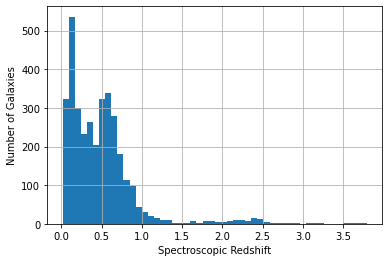

In [25]:
cnn_nn_best['specz'].hist(bins=50)
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Number of Galaxies')

Text(0, 0.5, 'Number of Galaxies')

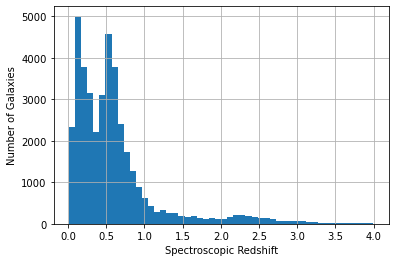

In [26]:
cnn_nn_worst['specz'].hist(bins=50)
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Number of Galaxies')

Text(0, 0.5, 'Number of Galaxies')

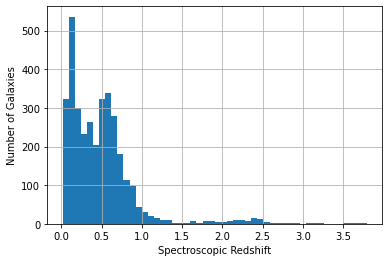

In [27]:
cnn_rf_best['specz'].hist(bins=50)
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Number of Galaxies')

Text(0, 0.5, 'Number of Galaxies')

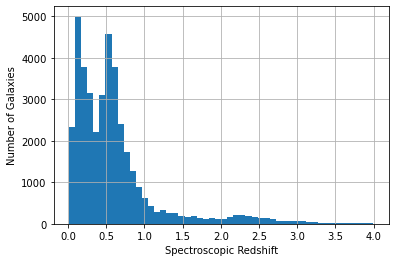

In [28]:
cnn_rf_worst['specz'].hist(bins=50)
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Number of Galaxies')

Text(0, 0.5, 'Number of Galaxies')

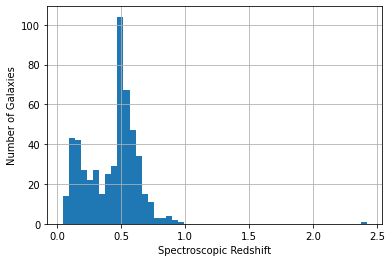

In [29]:
rf_best['specz'].hist(bins=50)
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Number of Galaxies')
# there is an anomoly because there is a small amount of galaxies at z > 2 for some reason
# I'll imshow these anomolous galalxies

Text(0, 0.5, 'Number of Galaxies')

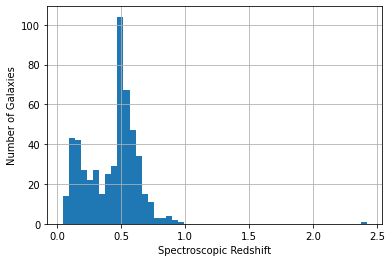

In [30]:
nn_best['specz'].hist(bins=50)
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Number of Galaxies')
# there is an anomoly because there is a small amount of galaxies at z > 2 for some reason
# I'll imshow these anomolous galalxies

In [31]:
# BEST PERFOMRING SECTION: Here, we inspect images that performed better than the RF/NN results. #
## The CNN absolute biases do not meet the LSST requirement while the RF/NN ones may or may not.

In [32]:
cnn_nn_selected_gal = cnn_nn_best.index[:NUM_GALAXIES]
cnn_nn_best_df = cnn_nn_best[:NUM_GALAXIES]

cnn_rf_selected_gal = cnn_rf_best.index[:NUM_GALAXIES]
cnn_rf_best_df = cnn_rf_best[:NUM_GALAXIES]

cnn_best_full = pd.concat([cnn_nn_best_df, cnn_rf_best_df]).drop_duplicates()

In [33]:
# HORIZONTAL DISPLAY PROTOTYPE
if TOGGLE_IMAGES:
    for current_gal in cnn_nn_selected_gal:
        fig, axs = plt.subplots(1, 5, figsize=(20, 20))
        fig.tight_layout()
        fig.suptitle(f'Object ID: {test_hf["object_id"][current_gal]}, Spectroscopic Redshift: {test_hf["specz_redshift"][current_gal]:.3f}, CNN-NN bias diff: {cnn_nn_best["cnn_nn_diff"][current_gal]:.3f}', y=0.64, fontsize=10)
        for i in range(0, 5):
            axs[i].imshow(test_hf['image'][current_gal, i, :, :])
            axs[i].set_title(f'{mag_alpha[i]} Band Magnitude: {test_hf[mags[i]][current_gal]:.3f}\nMagnitude Error: {test_hf[mags_err[i]][current_gal]:.3f}', fontsize=10)
           
        image_path = f'/data/HSC/HSC_v6/CNN_visualization_v1/cnn_best/{test_hf["object_id"][current_gal]}'
        if os.path.exists(image_path) == False:
            os.makedirs(image_path)
        fig.savefig(image_path + '/image.png')
        
        data_path = f'/data/HSC/HSC_v6/CNN_visualization_v1/cnn_best/{test_hf["object_id"][current_gal]}/uncategorized'
        if os.path.exists(data_path) == False:
            os.makedirs(data_path)
        cnn_best_full.loc[cnn_best_full['object_id'] == cnn_best_full.loc[current_gal]['object_id']].to_csv(data_path + '/data.csv', index=False)

In [34]:
# cnn_nn_selected_gal = cnn_nn_best.index[:NUM_GALAXIES]
# if TOGGLE_IMAGES:
#     for current_gal in cnn_nn_selected_gal:
#         fig, axs = plt.subplots(5, figsize=(30, 30))
#         fig.suptitle('Object ID: ' + str(test_hf['object_id'][current_gal]) + ', Spectroscopic Redshift: ' + str(test_hf['specz_redshift'][current_gal]) + ', CNN-NN bias diff: ' + str(cnn_nn_best['cnn_nn_diff'][current_gal]), y=0.9)
#         for i in range(0, 5):
#             axs[i].imshow(test_hf['image'][current_gal, i, :, :])

#             axs[i].set_title(str(mag_alpha[i]) + ' Band Magnitude: ' + str(test_hf[mags[i]][current_gal]) + ', Magnitude Error: ' + str(test_hf[mags_err[i]][current_gal]))

In [35]:
# HORIZONTAL DISPLAY PROTOTYPE
if TOGGLE_IMAGES:
    for current_gal in cnn_rf_selected_gal:
        fig, axs = plt.subplots(1, 5, figsize=(20, 20))
        fig.tight_layout()
        fig.suptitle(f'Object ID: {test_hf["object_id"][current_gal]}, Spectroscopic Redshift: {test_hf["specz_redshift"][current_gal]:.3f}, CNN-RF bias diff: {cnn_rf_best["cnn_rf_diff"][current_gal]:.3f}', y=0.64, fontsize=10)
        for i in range(0, 5):
            axs[i].imshow(test_hf['image'][current_gal, i, :, :])
            axs[i].set_title(f'{mag_alpha[i]} Band Magnitude: {test_hf[mags[i]][current_gal]:.3f}\nMagnitude Error: {test_hf[mags_err[i]][current_gal]:.3f}', fontsize=10)
            
        image_path = f'/data/HSC/HSC_v6/CNN_visualization_v1/cnn_best/{test_hf["object_id"][current_gal]}'
        if os.path.exists(image_path) == False:
            os.makedirs(image_path)
        fig.savefig(image_path + '/image.png')
        data_path = f'/data/HSC/HSC_v6/CNN_visualization_v1/cnn_best/{test_hf["object_id"][current_gal]}/uncategorized'
        if os.path.exists(data_path) == False:
            os.makedirs(data_path)
        cnn_best_full.loc[cnn_best_full['object_id'] == cnn_best_full.loc[current_gal]['object_id']].to_csv(data_path + '/data.csv', index=False)

In [36]:
print(f'Average spectroscopic redshift: {np.mean(cnn_nn_best.specz[:NUM_GALAXIES]):.3f}')

Average spectroscopic redshift: 0.418


In [37]:
print(f'Average spectroscopic redshift: {np.mean(cnn_rf_best.specz[:NUM_GALAXIES]):.3f}')

Average spectroscopic redshift: 0.199


In [38]:
print(f'Standard deviation of spectroscopic redshifts: {np.std(cnn_nn_best.specz[:NUM_GALAXIES]):.3f}')

Standard deviation of spectroscopic redshifts: 0.603


In [39]:
print(f'Standard deviation of spectroscopic redshifts: {np.std(cnn_rf_best.specz[:NUM_GALAXIES]):.3f}')

Standard deviation of spectroscopic redshifts: 0.229


In [40]:
print(f'Average g band magnitude (CNN-NN) {np.mean(cnn_nn_best.g_cmodel_mag[:NUM_GALAXIES]):.3f}')
print(f'Average r band magnitude (CNN-NN) {np.mean(cnn_nn_best.r_cmodel_mag[:NUM_GALAXIES]):.3f}')
print(f'Average i band magnitude (CNN-NN) {np.mean(cnn_nn_best.i_cmodel_mag[:NUM_GALAXIES]):.3f}')
print(f'Average z band magnitude (CNN-NN) {np.mean(cnn_nn_best.z_cmodel_mag[:NUM_GALAXIES]):.3f}')
print(f'Average y band magnitude (CNN-NN) {np.mean(cnn_nn_best.y_cmodel_mag[:NUM_GALAXIES]):.3f}')

Average g band magnitude (CNN-NN) 20.188
Average r band magnitude (CNN-NN) 19.883
Average i band magnitude (CNN-NN) 19.694
Average z band magnitude (CNN-NN) 19.556
Average y band magnitude (CNN-NN) 19.466


In [41]:
print(f'Average g band magnitude (CNN-RF) {np.mean(cnn_rf_best.g_cmodel_mag[:NUM_GALAXIES]):.3f}')
print(f'Average r band magnitude (CNN-RF) {np.mean(cnn_rf_best.r_cmodel_mag[:NUM_GALAXIES]):.3f}')
print(f'Average i band magnitude (CNN-RF) {np.mean(cnn_rf_best.i_cmodel_mag[:NUM_GALAXIES]):.3f}')
print(f'Average z band magnitude (CNN-RF) {np.mean(cnn_rf_best.z_cmodel_mag[:NUM_GALAXIES]):.3f}')
print(f'Average y band magnitude (CNN-RF) {np.mean(cnn_rf_best.y_cmodel_mag[:NUM_GALAXIES]):.3f}')

Average g band magnitude (CNN-RF) 20.086
Average r band magnitude (CNN-RF) 19.779
Average i band magnitude (CNN-RF) 19.588
Average z band magnitude (CNN-RF) 19.506
Average y band magnitude (CNN-RF) 19.451


In [42]:
print(f'Standard deviation of g band magnitudes (CNN-NN) {np.std(cnn_nn_best.g_cmodel_mag[:NUM_GALAXIES]):.3f}')
print(f'Standard deviation of r band magnitudes (CNN-NN) {np.std(cnn_nn_best.r_cmodel_mag[:NUM_GALAXIES]):.3f}')
print(f'Standard deviation of i band magnitudes (CNN-NN) {np.std(cnn_nn_best.i_cmodel_mag[:NUM_GALAXIES]):.3f}')
print(f'Standard deviation of z band magnitudes (CNN-NN) {np.std(cnn_nn_best.z_cmodel_mag[:NUM_GALAXIES]):.3f}')
print(f'Standard deviation of y band magnitudes (CNN-NN) {np.std(cnn_nn_best.y_cmodel_mag[:NUM_GALAXIES]):.3f}')

Standard deviation of g band magnitudes (CNN-NN) 0.988
Standard deviation of r band magnitudes (CNN-NN) 0.964
Standard deviation of i band magnitudes (CNN-NN) 0.916
Standard deviation of z band magnitudes (CNN-NN) 0.868
Standard deviation of y band magnitudes (CNN-NN) 0.798


In [43]:
print(f'Standard deviation of g band magnitudes (CNN-RF) {np.std(cnn_rf_best.g_cmodel_mag[:NUM_GALAXIES]):.3f}')
print(f'Standard deviation of r band magnitudes (CNN-RF) {np.std(cnn_rf_best.r_cmodel_mag[:NUM_GALAXIES]):.3f}')
print(f'Standard deviation of i band magnitudes (CNN-RF) {np.std(cnn_rf_best.i_cmodel_mag[:NUM_GALAXIES]):.3f}')
print(f'Standard deviation of z band magnitudes (CNN-RF) {np.std(cnn_rf_best.z_cmodel_mag[:NUM_GALAXIES]):.3f}')
print(f'Standard deviation of y band magnitudes (CNN-RF) {np.std(cnn_rf_best.y_cmodel_mag[:NUM_GALAXIES]):.3f}')

Standard deviation of g band magnitudes (CNN-RF) 0.686
Standard deviation of r band magnitudes (CNN-RF) 0.628
Standard deviation of i band magnitudes (CNN-RF) 0.579
Standard deviation of z band magnitudes (CNN-RF) 0.666
Standard deviation of y band magnitudes (CNN-RF) 0.673


In [44]:
print(f'Average absolute difference in absolute bias (CNN-NN): {np.mean(np.abs(cnn_nn_best.cnn_nn_diff[:NUM_GALAXIES])):.3f}')

Average absolute difference in absolute bias (CNN-NN): 0.924


In [45]:
print(f'Average difference in absolute bias (CNN-RF): {np.mean(np.abs(cnn_rf_best.cnn_rf_diff[:NUM_GALAXIES])):.3f}')

Average difference in absolute bias (CNN-RF): 0.906


In [46]:
print(f'Standard deviation of absolute biases (CNN-NN): {np.std(np.abs(cnn_nn_best.cnn_nn_diff[:NUM_GALAXIES])):.3f}')

Standard deviation of absolute biases (CNN-NN): 0.338


In [47]:
print(f'Standard deviation of absolute biases (CNN-RF): {np.std(np.abs(cnn_rf_best.cnn_rf_diff[:NUM_GALAXIES])):.3f}')

Standard deviation of absolute biases (CNN-RF): 0.267


In [48]:
overlap = list(set(cnn_nn_selected_gal) & set(cnn_rf_selected_gal))


print(f'Number of overlapping galaxies is: {len(overlap)} out of {NUM_GALAXIES} total galaxies displayed.')

Number of overlapping galaxies is: 14 out of 20 total galaxies displayed.


In [49]:
# WORST PERFOMRING CNN SECTION: Here, we inspect images that performed worse than the RF/NN results. #
## The CNN absolute biases meet the LSST requirement while the RF/NN ones may or may not.

In [50]:
cnn_nn_selected_gal = cnn_nn_worst.index[:NUM_GALAXIES]
cnn_nn_worst_df = cnn_nn_worst[:NUM_GALAXIES]

cnn_rf_selected_gal = cnn_rf_worst.index[:NUM_GALAXIES]
cnn_rf_worst_df = cnn_rf_worst[:NUM_GALAXIES]

cnn_worst_full = pd.concat([cnn_nn_worst_df, cnn_rf_worst_df]).drop_duplicates()

In [51]:
# HORIZONTAL DISPLAY PROTOTYPE
if TOGGLE_IMAGES:
    for current_gal in cnn_nn_selected_gal:
        fig, axs = plt.subplots(1, 5, figsize=(20, 20))
        fig.tight_layout()
        fig.suptitle(f'Object ID: {test_hf["object_id"][current_gal]}, Spectroscopic Redshift: {test_hf["specz_redshift"][current_gal]:.3f}, CNN-NN bias diff: {cnn_nn_worst["cnn_nn_diff"][current_gal]:.3f}', y=0.64, fontsize=10)
        for i in range(0, 5):
            axs[i].imshow(test_hf['image'][current_gal, i, :, :])
            axs[i].set_title(f'{mag_alpha[i]} Band Magnitude: {test_hf[mags[i]][current_gal]:.3f}\nMagnitude Error: {test_hf[mags_err[i]][current_gal]:.3f}', fontsize=10)
            
        image_path = f'/data/HSC/HSC_v6/CNN_visualization_v1/cnn_worst/{test_hf["object_id"][current_gal]}'
        if os.path.exists(image_path) == False:
            os.makedirs(image_path)
        fig.savefig(image_path + '/image.png')
        data_path = f'/data/HSC/HSC_v6/CNN_visualization_v1/cnn_worst/{test_hf["object_id"][current_gal]}/uncategorized'
        if os.path.exists(data_path) == False:
            os.makedirs(data_path)
        cnn_worst_full.loc[cnn_worst_full['object_id'] == cnn_worst_full.loc[current_gal]['object_id']].to_csv(data_path + '/data.csv', index=False)
        
        

In [52]:
# HORIZONTAL DISPLAY PROTOTYPE
if TOGGLE_IMAGES:
    for current_gal in cnn_rf_selected_gal:
        fig, axs = plt.subplots(1, 5, figsize=(20, 20))
        fig.tight_layout()
        fig.suptitle(f'Object ID: {test_hf["object_id"][current_gal]}, Spectroscopic Redshift: {test_hf["specz_redshift"][current_gal]:.3f}, CNN-RF bias diff: {cnn_rf_worst["cnn_rf_diff"][current_gal]:.3f}', y=0.64, fontsize=10)
        for i in range(0, 5):
            axs[i].imshow(test_hf['image'][current_gal, i, :, :])
            axs[i].set_title(f'{mag_alpha[i]} Band Magnitude: {test_hf[mags[i]][current_gal]:.3f}\nMagnitude Error: {test_hf[mags_err[i]][current_gal]:.3f}', fontsize=10)
        
        image_path = f'/data/HSC/HSC_v6/CNN_visualization_v1/cnn_worst/{test_hf["object_id"][current_gal]}'
        if os.path.exists(image_path) == False:
            os.makedirs(image_path)
        fig.savefig(image_path + '/image.png')
        
        data_path = f'/data/HSC/HSC_v6/CNN_visualization_v1/cnn_worst/{test_hf["object_id"][current_gal]}/uncategorized'
        if os.path.exists(data_path) == False:
            os.makedirs(data_path)
        cnn_worst_full.loc[cnn_worst_full['object_id'] == cnn_worst_full.loc[current_gal]['object_id']].to_csv(data_path + '/data.csv', index=False)

In [53]:
print(f'Average spectroscopic redshift: {np.mean(cnn_nn_worst.specz[:NUM_GALAXIES]):.3f}')

Average spectroscopic redshift: 0.529


In [54]:
print(f'Average spectroscopic redshift: {np.mean(cnn_rf_worst.specz[:NUM_GALAXIES]):.3f}')

Average spectroscopic redshift: 0.447


In [55]:
print(f'Standard deviation of spectroscopic redshifts: {np.std(cnn_nn_worst.specz[:NUM_GALAXIES]):.3f}')

Standard deviation of spectroscopic redshifts: 0.285


In [56]:
print(f'Standard deviation of spectroscopic redshifts: {np.std(cnn_rf_worst.specz[:NUM_GALAXIES]):.3f}')

Standard deviation of spectroscopic redshifts: 0.246


In [57]:
print(f'Average g band magnitude (CNN-NN) {np.mean(cnn_nn_worst.g_cmodel_mag[:NUM_GALAXIES]):.3f}')
print(f'Average r band magnitude (CNN-NN) {np.mean(cnn_nn_worst.r_cmodel_mag[:NUM_GALAXIES]):.3f}')
print(f'Average i band magnitude (CNN-NN) {np.mean(cnn_nn_worst.i_cmodel_mag[:NUM_GALAXIES]):.3f}')
print(f'Average z band magnitude (CNN-NN) {np.mean(cnn_nn_worst.z_cmodel_mag[:NUM_GALAXIES]):.3f}')
print(f'Average y band magnitude (CNN-NN) {np.mean(cnn_nn_worst.y_cmodel_mag[:NUM_GALAXIES]):.3f}')

Average g band magnitude (CNN-NN) 21.930
Average r band magnitude (CNN-NN) 21.280
Average i band magnitude (CNN-NN) 21.117
Average z band magnitude (CNN-NN) 20.933
Average y band magnitude (CNN-NN) 20.890


In [58]:
print(f'Average g band magnitude (CNN-RF) {np.mean(cnn_rf_worst.g_cmodel_mag[:NUM_GALAXIES]):.3f}')
print(f'Average r band magnitude (CNN-RF) {np.mean(cnn_rf_worst.r_cmodel_mag[:NUM_GALAXIES]):.3f}')
print(f'Average i band magnitude (CNN-RF) {np.mean(cnn_rf_worst.i_cmodel_mag[:NUM_GALAXIES]):.3f}')
print(f'Average z band magnitude (CNN-RF) {np.mean(cnn_rf_worst.z_cmodel_mag[:NUM_GALAXIES]):.3f}')
print(f'Average y band magnitude (CNN-RF) {np.mean(cnn_rf_worst.y_cmodel_mag[:NUM_GALAXIES]):.3f}')

Average g band magnitude (CNN-RF) 22.169
Average r band magnitude (CNN-RF) 21.573
Average i band magnitude (CNN-RF) 21.491
Average z band magnitude (CNN-RF) 21.303
Average y band magnitude (CNN-RF) 21.185


In [59]:
print(f'Standard deviation of g band magnitudes (CNN-NN) {np.std(cnn_nn_worst.g_cmodel_mag[:NUM_GALAXIES]):.3f}')
print(f'Standard deviation of r band magnitudes (CNN-NN) {np.std(cnn_nn_worst.r_cmodel_mag[:NUM_GALAXIES]):.3f}')
print(f'Standard deviation of i band magnitudes (CNN-NN) {np.std(cnn_nn_worst.i_cmodel_mag[:NUM_GALAXIES]):.3f}')
print(f'Standard deviation of z band magnitudes (CNN-NN) {np.std(cnn_nn_worst.z_cmodel_mag[:NUM_GALAXIES]):.3f}')
print(f'Standard deviation of y band magnitudes (CNN-NN) {np.std(cnn_nn_worst.y_cmodel_mag[:NUM_GALAXIES]):.3f}')

Standard deviation of g band magnitudes (CNN-NN) 1.577
Standard deviation of r band magnitudes (CNN-NN) 1.613
Standard deviation of i band magnitudes (CNN-NN) 1.654
Standard deviation of z band magnitudes (CNN-NN) 1.708
Standard deviation of y band magnitudes (CNN-NN) 1.755


In [60]:
print(f'Standard deviation of g band magnitudes (CNN-RF) {np.std(cnn_rf_worst.g_cmodel_mag[:NUM_GALAXIES]):.3f}')
print(f'Standard deviation of r band magnitudes (CNN-RF) {np.std(cnn_rf_worst.r_cmodel_mag[:NUM_GALAXIES]):.3f}')
print(f'Standard deviation of i band magnitudes (CNN-RF) {np.std(cnn_rf_worst.i_cmodel_mag[:NUM_GALAXIES]):.3f}')
print(f'Standard deviation of z band magnitudes (CNN-RF) {np.std(cnn_rf_worst.z_cmodel_mag[:NUM_GALAXIES]):.3f}')
print(f'Standard deviation of y band magnitudes (CNN-RF) {np.std(cnn_rf_worst.y_cmodel_mag[:NUM_GALAXIES]):.3f}')

Standard deviation of g band magnitudes (CNN-RF) 1.506
Standard deviation of r band magnitudes (CNN-RF) 1.508
Standard deviation of i band magnitudes (CNN-RF) 1.625
Standard deviation of z band magnitudes (CNN-RF) 1.650
Standard deviation of y band magnitudes (CNN-RF) 1.684


In [61]:
print(f'Average absolute difference in absolute bias (CNN-NN): {np.mean(np.abs(cnn_nn_worst.cnn_nn_diff[:NUM_GALAXIES])):.3f}')

Average absolute difference in absolute bias (CNN-NN): 1.085


In [62]:
print(f'Average difference in absolute bias (CNN-RF): {np.mean(np.abs(cnn_rf_worst.cnn_rf_diff[:NUM_GALAXIES])):.3f}')

Average difference in absolute bias (CNN-RF): 1.007


In [63]:
print(f'Standard deviation of absolute biases (CNN-NN): {np.std(np.abs(cnn_nn_worst.cnn_nn_diff[:NUM_GALAXIES])):.3f}')

Standard deviation of absolute biases (CNN-NN): 0.379


In [64]:
print(f'Standard deviation of absolute biases (CNN-RF): {np.std(np.abs(cnn_rf_worst.cnn_rf_diff[:NUM_GALAXIES])):.3f}')

Standard deviation of absolute biases (CNN-RF): 0.287


In [65]:
overlap = list(set(cnn_nn_selected_gal) & set(cnn_rf_selected_gal))


print(f'Number of overlapping galaxies is {len(overlap)} out of {NUM_GALAXIES} total galaxies displayed.')

Number of overlapping galaxies is 14 out of 20 total galaxies displayed.


In [66]:
## RF/NN best results. The RF/NN absolute biases meet the LSST requirement and the CNN ones failed.

In [67]:
nn_selected_gal = nn_best.index[:NUM_GALAXIES]
nn_best_df = nn_best[:NUM_GALAXIES]

rf_selected_gal = rf_best.index[:NUM_GALAXIES]
rf_best_df = rf_best[:NUM_GALAXIES]

nn_rf_best_full = pd.concat([nn_best_df, rf_best_df]).drop_duplicates()

In [68]:
# HORIZONTAL DISPLAY PROTOTYPE
if TOGGLE_IMAGES:
    for current_gal in nn_selected_gal:
        fig, axs = plt.subplots(1, 5, figsize=(20, 20))
        fig.tight_layout()
        fig.suptitle(f'Object ID: {test_hf["object_id"][current_gal]}, Spectroscopic Redshift: {test_hf["specz_redshift"][current_gal]:.3f}, CNN-NN bias diff: {nn_best["cnn_nn_diff"][current_gal]:.3f}', y=0.64, fontsize=10)
        for i in range(0, 5):
            axs[i].imshow(test_hf['image'][current_gal, i, :, :])
            axs[i].set_title(f'{mag_alpha[i]} Band Magnitude: {test_hf[mags[i]][current_gal]:.3f}\nMagnitude Error: {test_hf[mags_err[i]][current_gal]:.3f}', fontsize=10)
            
        image_path = f'/data/HSC/HSC_v6/CNN_visualization_v1/rf_best/{test_hf["object_id"][current_gal]}'
        if os.path.exists(image_path) == False:
            os.makedirs(image_path)
        fig.savefig(image_path + '/image.png')
        
        data_path = f'/data/HSC/HSC_v6/CNN_visualization_v1/rf_best/{test_hf["object_id"][current_gal]}/uncategorized'
        if os.path.exists(data_path) == False:
            os.makedirs(data_path)
        nn_rf_best_full.loc[nn_rf_best_full['object_id'] == nn_rf_best_full.loc[current_gal]['object_id']].to_csv(data_path + '/data.csv', index=False)

In [69]:
# HORIZONTAL DISPLAY PROTOTYPE
if TOGGLE_IMAGES:
    for current_gal in nn_selected_gal:
        fig, axs = plt.subplots(1, 5, figsize=(20, 20))
        fig.tight_layout()
        fig.suptitle(f'Object ID: {test_hf["object_id"][current_gal]}, Spectroscopic Redshift: {test_hf["specz_redshift"][current_gal]:.3f}, CNN-RF bias diff: {rf_best["cnn_rf_diff"][current_gal]:.3f}', y=0.64, fontsize=10)
        for i in range(0, 5):
            axs[i].imshow(test_hf['image'][current_gal, i, :, :])
            axs[i].set_title(f'{mag_alpha[i]} Band Magnitude: {test_hf[mags[i]][current_gal]:.3f}\nMagnitude Error: {test_hf[mags_err[i]][current_gal]:.3f}', fontsize=10)
            
        image_path = f'/data/HSC/HSC_v6/CNN_visualization_v1/nn_best/{test_hf["object_id"][current_gal]}'
        if os.path.exists(image_path) == False:
            os.makedirs(image_path)
        fig.savefig(image_path)
        
        data_path = f'/data/HSC/HSC_v6/CNN_visualization_v1/nn_best/{test_hf["object_id"][current_gal]}/uncategorized'
        if os.path.exists(data_path) == False:
            os.makedirs(data_path)
        nn_rf_best_full.loc[nn_rf_best_full['object_id'] == nn_rf_best_full.loc[current_gal]['object_id']].to_csv(data_path + '/data.csv', index=False)

In [70]:
print(f'Average spectroscopic redshift: {np.mean(nn_best.specz[:NUM_GALAXIES]):.3f}')

Average spectroscopic redshift: 0.488


In [71]:
print(f'Average spectroscopic redshift: {np.mean(rf_best.specz[:NUM_GALAXIES]):.3f}')

Average spectroscopic redshift: 0.465


In [72]:
print(f'Standard deviation of spectroscopic redshifts: {np.std(nn_best.specz[:NUM_GALAXIES]):.3f}')

Standard deviation of spectroscopic redshifts: 0.205


In [73]:
print(f'Standard deviation of spectroscopic redshifts: {np.std(rf_best.specz[:NUM_GALAXIES]):.3f}')

Standard deviation of spectroscopic redshifts: 0.214


In [74]:
print(f'Average g band magnitude (CNN-NN) {np.mean(nn_best.g_cmodel_mag[:NUM_GALAXIES]):.3f}')
print(f'Average r band magnitude (CNN-NN) {np.mean(nn_best.r_cmodel_mag[:NUM_GALAXIES]):.3f}')
print(f'Average i band magnitude (CNN-NN) {np.mean(nn_best.i_cmodel_mag[:NUM_GALAXIES]):.3f}')
print(f'Average z band magnitude (CNN-NN) {np.mean(nn_best.z_cmodel_mag[:NUM_GALAXIES]):.3f}')
print(f'Average y band magnitude (CNN-NN) {np.mean(nn_best.y_cmodel_mag[:NUM_GALAXIES]):.3f}')

Average g band magnitude (CNN-NN) 22.138
Average r band magnitude (CNN-NN) 21.012
Average i band magnitude (CNN-NN) 20.325
Average z band magnitude (CNN-NN) 20.023
Average y band magnitude (CNN-NN) 19.838


In [75]:
print(f'Average g band magnitude (CNN-RF) {np.mean(rf_best.g_cmodel_mag[:NUM_GALAXIES]):.3f}')
print(f'Average r band magnitude (CNN-RF) {np.mean(rf_best.r_cmodel_mag[:NUM_GALAXIES]):.3f}')
print(f'Average i band magnitude (CNN-RF) {np.mean(rf_best.i_cmodel_mag[:NUM_GALAXIES]):.3f}')
print(f'Average z band magnitude (CNN-RF) {np.mean(rf_best.z_cmodel_mag[:NUM_GALAXIES]):.3f}')
print(f'Average y band magnitude (CNN-RF) {np.mean(rf_best.y_cmodel_mag[:NUM_GALAXIES]):.3f}')

Average g band magnitude (CNN-RF) 21.873
Average r band magnitude (CNN-RF) 20.735
Average i band magnitude (CNN-RF) 20.045
Average z band magnitude (CNN-RF) 19.742
Average y band magnitude (CNN-RF) 19.555


In [76]:
print(f'Standard deviation of g band magnitudes (CNN-NN) {np.std(nn_best.g_cmodel_mag[:NUM_GALAXIES]):.3f}')
print(f'Standard deviation of r band magnitudes (CNN-NN) {np.std(nn_best.r_cmodel_mag[:NUM_GALAXIES]):.3f}')
print(f'Standard deviation of i band magnitudes (CNN-NN) {np.std(nn_best.i_cmodel_mag[:NUM_GALAXIES]):.3f}')
print(f'Standard deviation of z band magnitudes (CNN-NN) {np.std(nn_best.z_cmodel_mag[:NUM_GALAXIES]):.3f}')
print(f'Standard deviation of y band magnitudes (CNN-NN) {np.std(nn_best.y_cmodel_mag[:NUM_GALAXIES]):.3f}')

Standard deviation of g band magnitudes (CNN-NN) 1.717
Standard deviation of r band magnitudes (CNN-NN) 1.806
Standard deviation of i band magnitudes (CNN-NN) 1.801
Standard deviation of z band magnitudes (CNN-NN) 1.860
Standard deviation of y band magnitudes (CNN-NN) 1.887


In [77]:
print(f'Standard deviation of g band magnitudes (CNN-RF) {np.std(rf_best.g_cmodel_mag[:NUM_GALAXIES]):.3f}')
print(f'Standard deviation of r band magnitudes (CNN-RF) {np.std(rf_best.r_cmodel_mag[:NUM_GALAXIES]):.3f}')
print(f'Standard deviation of i band magnitudes (CNN-RF) {np.std(rf_best.i_cmodel_mag[:NUM_GALAXIES]):.3f}')
print(f'Standard deviation of z band magnitudes (CNN-RF) {np.std(rf_best.z_cmodel_mag[:NUM_GALAXIES]):.3f}')
print(f'Standard deviation of y band magnitudes (CNN-RF) {np.std(rf_best.y_cmodel_mag[:NUM_GALAXIES]):.3f}')

Standard deviation of g band magnitudes (CNN-RF) 1.848
Standard deviation of r band magnitudes (CNN-RF) 1.907
Standard deviation of i band magnitudes (CNN-RF) 1.889
Standard deviation of z band magnitudes (CNN-RF) 1.934
Standard deviation of y band magnitudes (CNN-RF) 1.959


In [78]:
print(f'Average absolute difference in absolute bias (CNN-NN): {np.mean(np.abs(nn_best.cnn_nn_diff[:NUM_GALAXIES])):.3f}')

Average absolute difference in absolute bias (CNN-NN): 0.069


In [79]:
print(f'Average difference in absolute bias (CNN-RF): {np.mean(np.abs(rf_best.cnn_rf_diff[:NUM_GALAXIES])):.3f}')

Average difference in absolute bias (CNN-RF): 0.069


In [80]:
print(f'Standard deviation of absolute biases (CNN-NN): {np.std(np.abs(nn_best.cnn_nn_diff[:NUM_GALAXIES])):.3f}')

Standard deviation of absolute biases (CNN-NN): 0.053


In [81]:
print(f'Standard deviation of absolute biases (CNN-RF): {np.std(np.abs(rf_best.cnn_rf_diff[:NUM_GALAXIES])):.3f}')

Standard deviation of absolute biases (CNN-RF): 0.053


In [82]:
overlap = list(set(nn_selected_gal) & set(rf_selected_gal))


print(f'Number of overlapping galaxies is: {len(overlap)} out of {NUM_GALAXIES} total galaxies displayed.')

Number of overlapping galaxies is: 19 out of 20 total galaxies displayed.
